In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Average plane Z positions
Z_DC31_X = -(10.3+7.3-1.7-4.7)/4.0
Z_DC31_Y = -(4.3+1.3-7.7-10.7)/4.0
Z_DC32_X = -(4.5+1.5)/2.0
Z_DC32_Y = -(-1.5-4.5)/2.0

# Detector Z positions
Z_DC31 = -271.5 # mm
Z_DC32 = 787.97 # mm
Z_SRPPAC = 0.0 # mm

spark = SparkSession.builder.master("local[10]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

df = spark.read.parquet("parquet/run1024_joined.parquet")
df.show(5)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/15 22:09:37 WARN Utils: Your hostname, gpuana02, resolves to a loopback address: 127.0.1.1; using 192.168.1.216 instead (on interface enp4s0)
26/01/15 22:09:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/15 22:09:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


+---------+-------------------+-------------------+------------------+-------------------+------------------+--------------------+
|hbfNumber|           sr_pos_x|           sr_pos_y|            dc31_x|             dc31_y|            dc32_x|              dc32_y|
+---------+-------------------+-------------------+------------------+-------------------+------------------+--------------------+
|  5273634|-1.0117219388484955|   -5.5006143450737|0.5224566459655762|-1.2129138708114624|              NULL|-0.40310394763946533|
|  5305144|-14.954297304153442| -9.884232699871063|10.651288986206055| -2.930957317352295|              NULL|                NULL|
|  5305970|-14.728004693984985|  3.340811014175415|11.102699279785156|  9.551088333129883| 12.32029914855957|  11.915654182434082|
|  5324844|   6.81179615855217|-1.5448322892189026| -7.18011474609375|  4.186327934265137|              NULL|   8.886792182922363|
|  5279727| -8.206592857837677| -2.829498291015625|              NULL| 1.4356787204

In [2]:
L2X = Z_DC32 - Z_SRPPAC + Z_DC32_X
L2Y = Z_DC32 - Z_SRPPAC + Z_DC32_Y
L1X = Z_DC31 - Z_SRPPAC + Z_DC31_X
L1Y = Z_DC31 - Z_SRPPAC + Z_DC31_Y

df_chk = df.withColumn("interp_mwdc_x", F.expr(f"-(dc31_x * {L2X} - dc32_x * {L1X})/(ABS({L1X}) + ABS({L2X}))")) \
           .withColumn("interp_mwdc_y", F.expr(f"(dc31_y * {L2Y} - dc32_y * {L1Y})/(ABS({L1Y}) + ABS({L2Y}))"))
df_chk.show(5)

+---------+-------------------+-------------------+------------------+-------------------+------------------+--------------------+-------------------+-------------------+
|hbfNumber|           sr_pos_x|           sr_pos_y|            dc31_x|             dc31_y|            dc32_x|              dc32_y|      interp_mwdc_x|      interp_mwdc_y|
+---------+-------------------+-------------------+------------------+-------------------+------------------+--------------------+-------------------+-------------------+
|  5273634|-1.0117219388484955|   -5.5006143450737|0.5224566459655762|-1.2129138708114624|              NULL|-0.40310394763946533|               NULL|-1.0077990253168796|
|  5305144|-14.954297304153442| -9.884232699871063|10.651288986206055| -2.930957317352295|              NULL|                NULL|               NULL|               NULL|
|  5305970|-14.728004693984985|  3.340811014175415|11.102699279785156|  9.551088333129883| 12.32029914855957|  11.915654182434082|-11.41799910325

Statistics:
[[0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 2.663e+03 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00]]


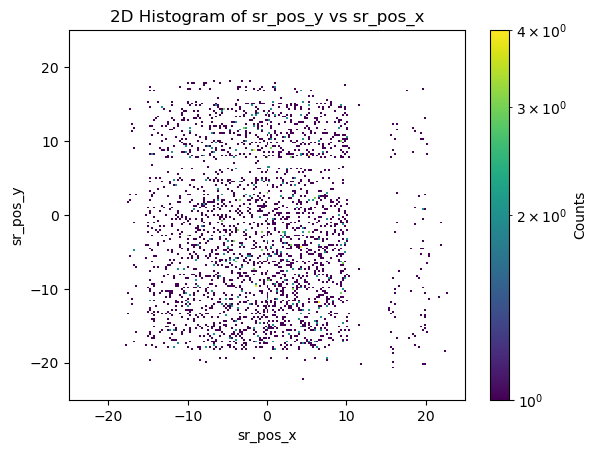

Statistics:
[[0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 1.401e+03 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00]]


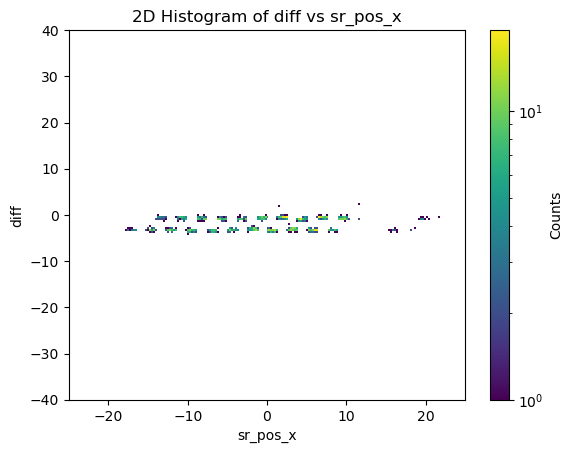

Statistics:
[[   0.    0.    0.]
 [   0. 1168.    0.]
 [   0.    0.    0.]]


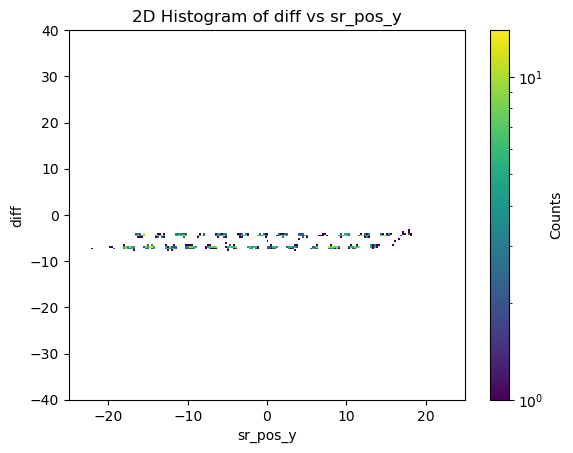

Total entries: 1402, Underflow: 0, Inside: 1402, Overflow: 0


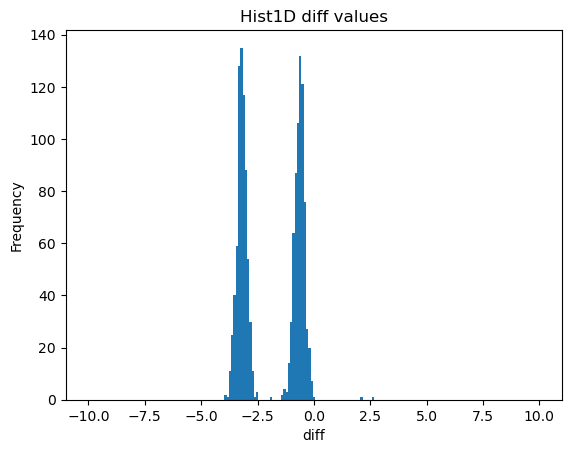

Total entries: 1168, Underflow: 0, Inside: 1168, Overflow: 0


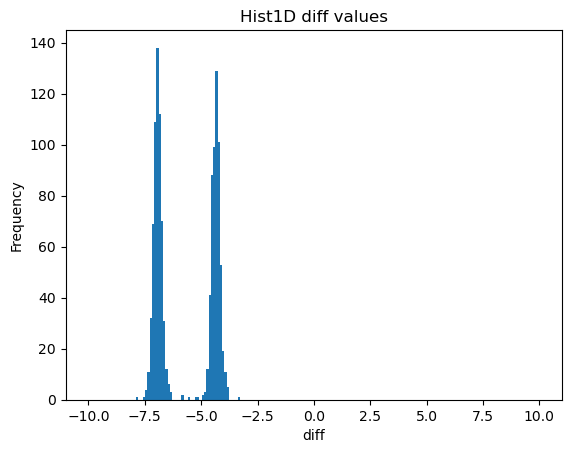

In [3]:
from hist.sparkHist2d import Hist2D
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

h = Hist2D(df_chk, ["sr_pos_x", "sr_pos_y"], [200,200], [[-25,25], [-25,25]], norm=LogNorm(), interpolation='none')
plt.show()
h = Hist2D(df_chk.withColumn("diff", F.expr("sr_pos_x - interp_mwdc_x")), ["sr_pos_x", "diff"], [200,200], [[-25,25], [-40,40]], norm=LogNorm(), interpolation='none')
plt.show()
h = Hist2D(df_chk.withColumn("diff", F.expr("sr_pos_y - interp_mwdc_y")), ["sr_pos_y", "diff"], [200,200], [[-25,25], [-40,40]], norm=LogNorm(), interpolation='none')
plt.show()
from hist.sparkHist1d import Hist1D
h = Hist1D(df_chk.withColumn("diff", F.expr("sr_pos_x - interp_mwdc_x")), "diff", 200, [-10,10])
plt.show()
h = Hist1D(df_chk.withColumn("diff", F.expr("sr_pos_y - interp_mwdc_y")), "diff", 200, [-10,10])

Total entries: 1168, Underflow: 0, Inside: 1168, Overflow: 0


Output()

Output()

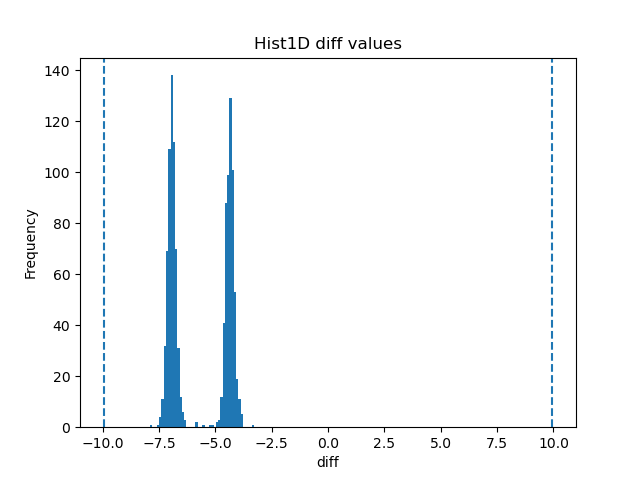

In [7]:
%matplotlib widget

plt.clf()

from hist.sparkHist1d import Hist1D
Hist1D(df_chk.withColumn("diff", F.expr("sr_pos_y - interp_mwdc_y")), "diff", 200, [-10,10])

from matplotlib import pyplot as plt
from hist.fitHist1d import FitHist1DGauss
FitHist1DGauss()
plt.show()

